In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier



In [34]:
origdf = pd.read_pickle("./gazeldataraw.pkl")
origdf.head(1)

,Subject,Set,Gesture Target Name,Gaze Target,Timestamp,Target Gesture,Target Gaze,Detected Gesture,Detected Gaze,Headsize Hist,Embeddings Hist,Gazepreds Hist,Gestpreds Hist,IMU Hist,Face Detection Hist,Grid?,Calib?,Gaze Target XY,Raw Gazepreds Hist
0,0,grid1_results,Left flick,2,1616861680190,3,2,3,2.0,"[0.15474085291843467, 0.15339179082189278, 0.1...","[[-0.1815185546875, 0.4033203125, -1.150390505...","[[0.6361377280284799, 0.16515855730109275], [0...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[-1.4482886795351362, 0.3025457372458007, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True,False,"[0.3333333333333333, 0.375]","[[0.58154296875, 0.5170899033546448], [0.46801..."


In [35]:
########### Flatten the IMU data from 3x3 to 9x1
# IMU is in format: Linear Accelerometer, Angular Accelerometer (both x,y,z), then Gyroscope (alpha, beta, gamma)
tmp = origdf['IMU Hist']
flatTmp = [np.array(x).reshape((9,-1)) for x in tmp]
origdf['IMU Hist'] = flatTmp

In [70]:
# Remove first 1.2 sec of the IMU hists to segregate the gaze and gesture parts
df = origdf.copy()
slowHistLens = np.array([len(x) for x in df['Embeddings Hist']])
fastHistLens = np.array([len(x[0]) for x in df['IMU Hist']])
conversion = np.divide(fastHistLens, slowHistLens)

startInd = 12 #gaze window
gestureStarts = (conversion*startInd).astype(int)
IMUbystart = list(map(lambda z: [x[z[1]:] for x in z[0]], zip(df['IMU Hist'], gestureStarts)))


df['Headsize Hist'] = list(map(lambda x: x[startInd:], df['Headsize Hist']))
df['IMU Hist'] = IMUbystart
df['Headsize Hist'] = df['Headsize Hist'][[len(x[0]) > 70 for x in df['IMU Hist']]]
df['IMU Hist'] = df['IMU Hist'][[len(x[0]) > 70 for x in df['IMU Hist']]]
df = df.dropna()

print("Data len:", len(df))

Data len: 3636


In [37]:
# plt.plot([f(x+180,360)-180 for x in df["IMU Hist"][14][8]])
# plt.plot(df["IMU Hist"][0][7])

In [71]:
# function modmod(a, n){ return a - Math.floor(a/n) * n }
# a = modmod((a + 180), 360) - 180;
# sorted([len(x[0]) for x in df['IMU Hist']])
# [f(x+180,360)-180 for x in df["IMU Hist"][0][6]]


## Fix angle stuff
f = lambda a,n: a - (a//n)*n
g = lambda ax: [f(x+180,360)-180 for x in ax]
tmp = [x[:6] + [g(x[6]),g(x[7]),g(x[8])] for x in df['IMU Hist']]
df['IMU Hist'] = tmp


# Add headsize to the IMU hist
[df['IMU Hist'].iloc[i].append(x) for i,x in enumerate(df['Headsize Hist'])];

In [72]:
# Feature extraction
from sklearn.metrics import confusion_matrix

# featFuncs = [np.mean, np.max, np.min, np.std, lambda x: np.max(x)-np.min(x), \
#              lambda x: np.sum(np.abs(x)), lambda x: np.polyfit(x,range(len(x)),2)[0], lambda x: np.polyfit(x,range(len(x)),2)[1]]
featFuncs = [np.mean, np.max, np.min, np.std, lambda x: np.max(x)-np.min(x), \
             #np.sum, lambda x: np.sum(np.abs(x)),
             lambda x: np.polyfit(range(len(x)),x,1)[0],
             lambda x: np.polyfit(range(len(x)),x,2)[0],
             lambda x: np.polyfit(range(len(x)),x,2)[1],
             lambda x: x[-1]-x[0]]
# zero crossing 
# mean RMS
# fit linear regressor

featurize9 = lambda y: [[f(x) for f in featFuncs] for x in y]
def pullFeet(X):
    featureVecs = [featurize9(np.array(x)) for x in X]
    flatFeatVecs = np.array([np.array(x).flatten() for x in featureVecs])
    return flatFeatVecs

def runOnAllButI(df, i):
    data = df[df['Subject'] != i]
    trainX = data['IMU Hist']
    trainY = data['Target Gesture'].to_numpy()

    test = df[df['Subject'] == i]
    testX = test['IMU Hist']
    testY = test['Target Gesture'].to_numpy()

    # Remove tilts from the dataset
    trainX = trainX[(trainY != 2) & (trainY != 4)]
    trainY = trainY[(trainY != 2) & (trainY != 4)]

    # Remove tilts from the dataset
    testX = testX[(testY != 2) & (testY != 4)]
    testY = testY[(testY != 2) & (testY != 4)]    
    
    feetX = pullFeet(trainX)
    
    clf = ExtraTreesClassifier(n_estimators=150)
    clf.fit(feetX, trainY)
    outY = clf.predict(pullFeet(testX))

    
    acc = accuracy_score(outY, testY)
    conf = confusion_matrix(outY,testY)
    return acc,conf,(outY, testY)

In [73]:
accs = []
confs = []
Ys = []
for i in range(9):
    acc,conf,Y = runOnAllButI(df, i)
    print("Subject:",i,", Accuracy:", acc)
    accs.append(acc)
    confs.append(conf)
    Ys.append(Y)

print()
print("Averaged:", sum(accs)/len(accs))
allCMs = sum(confs)

Subject: 0 , Accuracy: 0.9965870307167235
Subject: 1 , Accuracy: 0.8687943262411347
Subject: 2 , Accuracy: 1.0
Subject: 3 , Accuracy: 0.9496124031007752
Subject: 4 , Accuracy: 1.0
Subject: 5 , Accuracy: 0.9929577464788732
Subject: 6 , Accuracy: 0.9965986394557823
Subject: 7 , Accuracy: 0.9726962457337884
Subject: 8 , Accuracy: 0.9891304347826086

Averaged: 0.9740418696121874


In [74]:
print("Std Dev", np.std(accs))

Std Dev 0.04031248957457418


In [115]:
np.savetxt("yea.csv", normedAllCM, delimiter=",")

Text(0.5, 1.05, 'GAZEL Gesture Classifier Confusion Matrix')

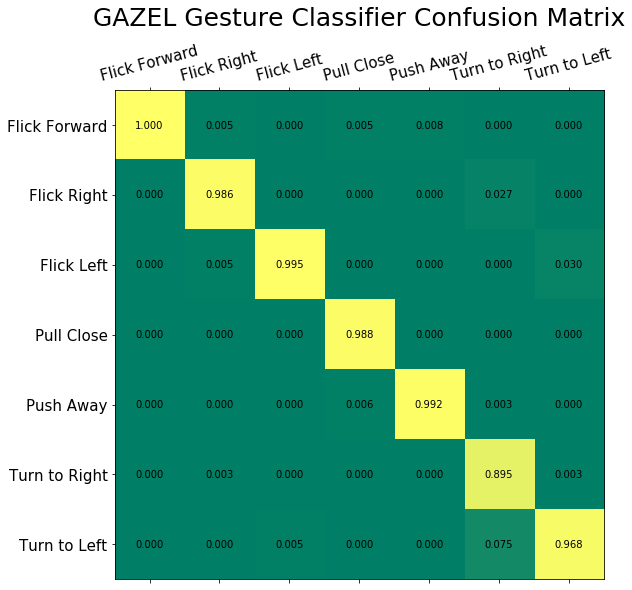

In [113]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from sklearn.metrics import confusion_matrix

allCMs = sum(confs)
denoms = np.sum(allCMs,axis=0)
normedAllCM = [x/y for (x,y) in zip(allCMs, denoms)]



# gestLabels = ["Forward flick", "Right flick", "Right tilt", "Left flick", "Left tilt", "Pull close", "Push away", "Turn to right", "Turn to left"];
# gestLabels = ["Forward flick", "Right flick", "Left flick", "Pull close", "Push away", "Turn to right", "Turn to left"];
gestLabels = ["Flick Forward", "Flick Right", "Flick Left", "Pull Close", "Push Away", "Turn to Right", "Turn to Left"]
fig, ax = plt.subplots(figsize=(9,9))
# ax.matshow(normedAllCM)
ax.matshow(normedAllCM,cmap = "summer")
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels(gestLabels, fontsize = 15)

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(gestLabels, rotation = 15, fontsize = 15)

# ax.set_xlabel

for (i, j), z in np.ndenumerate(normedAllCM):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

ax.set_title("GAZEL Gesture Classifier Confusion Matrix", pad=40, fontsize=25)

In [102]:
# np.save("confusionmatrix.csv", allCMs)
np.savetxt("confusionmatrix.csv", allCMs,delimiter=",")

In [42]:
feetX2 = pullFeet(testX)

In [51]:
import random
import time

acc = 0
for i in range(100):
    now = time.time()
    clf.predict([feetX2[int(random.random()*len(feetX2))]])
    acc += (time.time()-now)
print(acc)

1.5792083740234375


In [52]:
1/(acc/100)

63.32286583892942

In [22]:
data = df[df['Subject'] != i]
trainX = data['IMU Hist']
trainY = data['Target Gesture'].to_numpy()

test = df[df['Subject'] == i]
testX = test['IMU Hist']
testY = test['Target Gesture'].to_numpy()


clf = ExtraTreesClassifier(n_estimators=150)

feetX = pullFeet(trainX)
clf.fit(feetX, trainY)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

<BarContainer object of 90 artists>

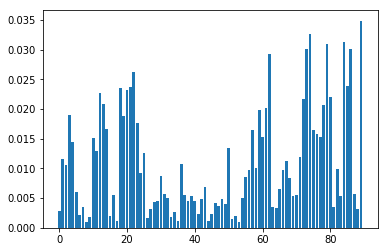

In [32]:
# import matplotlib.pyplot as plt
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)

# len(clf.feature_importances_)

In [25]:
outY, testY = Ys[0]



{i:x for i,x in enumerate(gestLabels)}
confusion_matrix(testY, outY , labels=[0,1,2,3,4,5,6,7,8])


array([[42,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16, 26,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 42,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8, 34,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 39,  3,  0,  0],
       [ 0,  0,  0,  0,  0, 22, 20,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 42,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1, 40]])

In [299]:
testY

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8,
       8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5,
       8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 7,
       7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5,
       5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,

In [268]:
# List of classifier models
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC


from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import mean_absolute_error,accuracy_score
import scipy
mode = scipy.stats.mode

import copy
dcopy = copy.deepcopy

models = [
    KNeighborsClassifier(n_neighbors=14),
    ExtraTreesClassifier(),
    ExtraTreesClassifier(n_estimators=100),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=100),
    SGDClassifier(),
    LogisticRegression(),
    SVC(),
    LinearSVC()
]


In [271]:

accsOfGod = []
for model in models:
    tmp1 = runOnAllButI(df, 1)
    tmp2 = runOnAllButI(df, 3)
    accsOfGod.append([tmp1, tmp2])
    
    print(model)
    print(tmp1)
    print(tmp2)
    print()
    
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')
0.8228882833787466
0.8154269972451791

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
0.8147138964577657
0.8154269972451791

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_s

In [273]:
tmp = zip(models,[sum(x)*.5 for x in accsOfGod])
for i in tmp:
    print(i[0])
    print(i[1])
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')
0.8191576403119629

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
0.8150704468514725

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
  

In [233]:
outY


array([0, 0, 0, ..., 4, 4, 4])